Syndrome measurements: {'1100 00000': 1024}


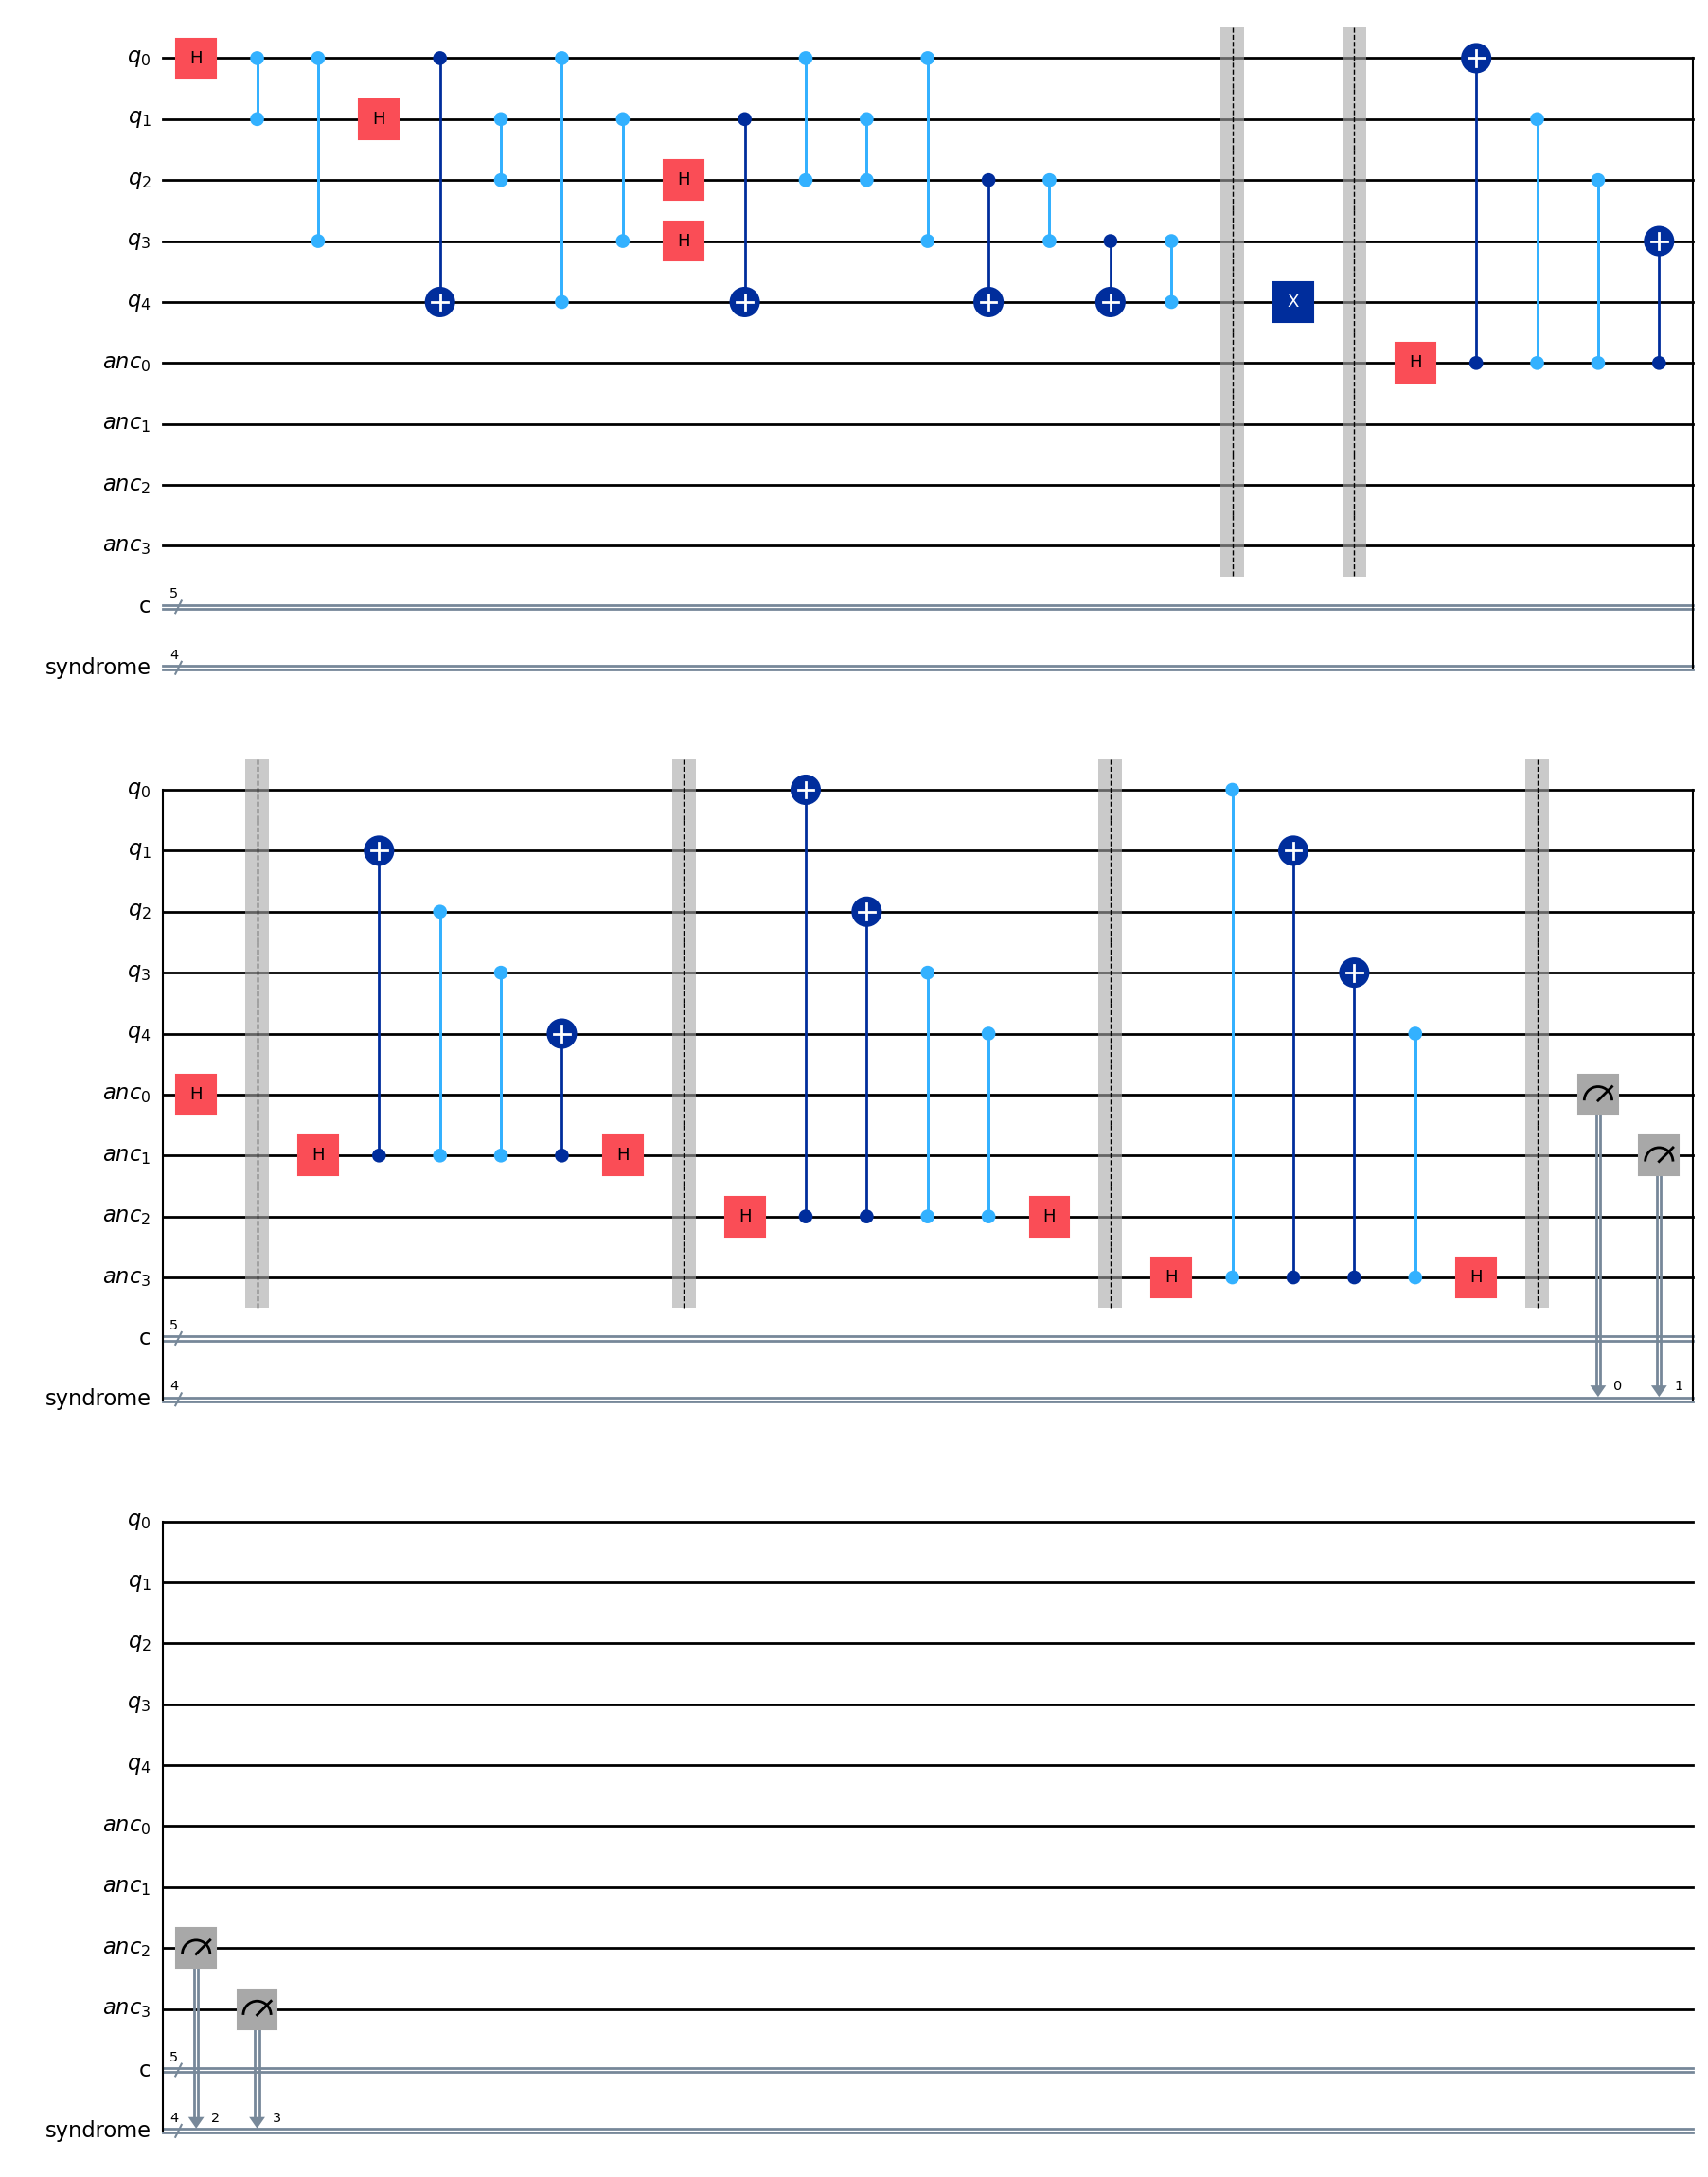

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


# initialise circuit
qr = QuantumRegister(5, 'q')  # 5 data qubits (q0 to q4)
anc = QuantumRegister(4, 'anc')  # 4 ancilla qubits for stabilizer measurements
cr = ClassicalRegister(5, 'c')  # classical register
syndrome = ClassicalRegister(4, 'syndrome')  # classical register for syndrome
qc = QuantumCircuit(qr, anc, cr, syndrome)

####################################################################################################
# STEP 1: ENCODING
####################################################################################################

# https://quantumcomputing.stackexchange.com/questions/32697/how-to-best-represent-5-qbit-codeword-operator-in-qiskit

# we need to encode our logical qubit q0 with the four ancilla qubits q1-4
# we can check our encoding has worked correctly by running the commented section
# below our encoding. If we have performed this correctly, we will find each component
# of |0\rangle has magnitude 0.25 with corresponding sign https://en.wikipedia.org/wiki/Five-qubit_error_correcting_code

qc.h(qr[0])
qc.cz(qr[0], qr[1])
qc.cz(qr[0], qr[3])
qc.cx(qr[0], qr[4])
qc.cz(qr[0], qr[4])

qc.h(qr[1])
qc.cz(qr[1], qr[2])
qc.cz(qr[1], qr[3])
qc.cx(qr[1], qr[4])

qc.h(qr[2])
qc.cz(qr[2], qr[0])
qc.cz(qr[2], qr[1])
qc.cx(qr[2], qr[4])

qc.h(qr[3])
qc.cz(qr[3], qr[0])
qc.cz(qr[3], qr[2])
qc.cx(qr[3], qr[4])
qc.cz(qr[3], qr[4])

####################################################################################################
# uncomment to verify encoding
####################################################################################################

# Simulate the circuit to get the statevector
#simulator = AerSimulator()
#qc.save_statevector()  # Save the statevector to inspect the final state
#job = simulator.run(qc)
#result = job.result()
#statevector = result.get_statevector(qc)

# Print the statevector (only non-zero components)
#print("Final statevector (non-zero components):")
#for idx, amp in enumerate(statevector):
#    if abs(amp) > 1e-10:  # Only print non-zero amplitudes
#        state = format(idx, '05b')  # 5-bit binary string
#        print(f"State |{state}> : {amp:.3f}")

####################################################################################################
# STEP 2: ERRORS
####################################################################################################

qc.barrier()
qc.x(qr[4])
qc.barrier()

####################################################################################################
# STEP 3: STABILISER MEASUREMENT
####################################################################################################

# S1 = XZZXI
qc.h(anc[0])
qc.cx(anc[0], qr[0])  # X0
qc.cz(anc[0], qr[1])  # Z1
qc.cz(anc[0], qr[2])  # Z2
qc.cx(anc[0], qr[3])  # X3
qc.h(anc[0])

qc.barrier()

# S2 = IXZZX
qc.h(anc[1])
qc.cx(anc[1], qr[1])  # X1
qc.cz(anc[1], qr[2])  # Z2
qc.cz(anc[1], qr[3])  # Z3
qc.cx(anc[1], qr[4])  # X4
qc.h(anc[1])

qc.barrier()

# S3 = XIXZZ
qc.h(anc[2])
qc.cx(anc[2], qr[0])  # X0
qc.cx(anc[2], qr[2])  # X2
qc.cz(anc[2], qr[3])  # Z3
qc.cz(anc[2], qr[4])  # Z4
qc.h(anc[2])

qc.barrier()

# S4 = ZXIXZ
qc.h(anc[3])
qc.cz(anc[3], qr[0])  # Z0
qc.cx(anc[3], qr[1])  # X1
qc.cx(anc[3], qr[3])  # X3
qc.cz(anc[3], qr[4])  # Z4
qc.h(anc[3])

qc.barrier()

for i in range(4):
    qc.measure(anc[i], syndrome[i])

# simulate the circuit
simulator = AerSimulator()
job = simulator.run(qc)
result = job.result()
counts = result.get_counts()

# print the syndrome measurements
print("Syndrome measurements:", counts)

qc.draw(output='mpl', filename='531css.png')